In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, binom
import math


In [15]:
L = 5
gamma = 0.95


In [16]:
df1 = pd.read_csv('data_policy1.csv', header = None).rename(columns = {0: 'st', 1: 'at', 2: 'rt', 3: 'st1'})
df2 = pd.read_csv('data_policy2.csv', header = None).rename(columns = {0: 'st', 1: 'at', 2: 'rt', 3: 'st1'})

In [17]:
def modelbased(data, alpha = 0.01, T = 25000):
    gamma = 0.95
    L = 5
    S = 5

    data = data[0:T]

    N_ss = [[0 for i in range(L)] for j in range(L)]
    for s in range(L):
        for s_m in range(L):
            N_ss[s][s_m] = len(data[(data['st'] == s) & (data['st1'] == s_m)])
    P_ss = np.array([[(N_ss[row][ele] + alpha) / (sum(N_ss[row]) + (alpha * S)) for ele in range(5)] for row in range(5)])

    r_s = [0 for i in range(L)]
    for s in range(L):
        r_s[s] = (sum(data[data['st'] == s]['rt']) + alpha) / (sum(N_ss[s]) + alpha)

    V_t = np.linalg.inv(np.identity(L) - gamma * P_ss) @ np.array(r_s)

    return V_t

def TD(data, alpha0, gamma):
    V_t_arr = np.array([0, 0, 0, 0, 0])
    V_t = [0.5 for i in range(5)]
    V_t1 = [0.0 for i in range(5)]
    for t in range(len(data)):
        s = data['st'][t]
        if alpha0 == "alpha_a":
            alpha = 10 / ((t+1)**(2/3) + 1)
        if alpha0 == "alpha_b":
            N_t = sum((data[:t+1]['st'] == s) & (data[:t+1]['at'] == data['at'][t]))
            alpha = 10 / (N_t**(2/3) + 1)
            
        #get V_{t+1}
        V_t1 = V_t.copy()
        V_t1[s] += alpha * (data['rt'][t] + (gamma * (V_t[data['st1'][t]])) - V_t[s])
        V_t = V_t1.copy()
        V_t_arr = np.vstack([V_t_arr, V_t])

    return V_t_arr[1:], V_t


In [18]:
print("data 1")
model_df1 = modelbased(df1, alpha = 1/5)
print("model based: ", np.round(model_df1, decimals=2), "\n")
TD_df1_alphaa_arr, TD_df1_alphaa = TD(df1, "alpha_a", gamma)
print("TD (alpha_a): ", np.round(TD_df1_alphaa, decimals=2), "\n")
TD_df1_alphab_arr, TD_df1_alphab = TD(df1, "alpha_b", gamma)
print("TD (alpha_b): ", np.round(TD_df1_alphab, decimals=2), "\n")

print("data 2")
model_df2 = modelbased(df2, alpha = 1/5)
print("model based: ", np.round(model_df2, decimals=2), "\n")
TD_df2_alphaa_arr, TD_df2_alphaa = TD(df2, "alpha_a", gamma)
print("TD (alpha_a): ", np.round(TD_df2_alphaa, decimals=2), "\n")
TD_df2_alphab_arr, TD_df2_alphab = TD(df2, "alpha_b", gamma)
print("TD (alpha_b): ", np.round(TD_df2_alphab, decimals=2), "\n")

data 1
model based:  [ 6.12  6.71  7.59  8.76 10.06] 

TD (alpha_a):  [1.23 5.35 7.28 8.5  9.82] 

TD (alpha_b):  [5.89 6.69 7.37 8.57 9.88] 

data 2
model based:  [0.41 0.39 0.43 0.66 1.39] 

TD (alpha_a):  [0.41 0.39 0.43 0.59 1.36] 

TD (alpha_b):  [0.36 0.32 0.34 0.38 1.61] 



In [19]:
P_ss1 = np.array([[0.6, 0.4, 0, 0, 0],
                [0.05, 0.55, 0.4, 0, 0],
                [0, 0.05, 0.55, 0.4, 0],
                [0, 0, 0.05, 0.55, 0.4],
                [0, 0, 0, 0.4, 0.6]])

P_ss2 = np.array([[0.8, 0.2, 0, 0, 0], 
                  [0.525, 0.275, 0.2, 0, 0], 
                  [0, 0.525, 0.275, 0.2, 0], 
                  [0, 0, 0.525, 0.275, 0.2],
                  [0, 0, 0, 0.7, 0.3]])
r_s1 = np.array([0, 0, 0, 0, 1])
r_s2 = np.array([0.025, 0, 0, 0, 0.5])

V_star1 = np.linalg.inv(np.identity(L) - gamma * P_ss1) @ r_s1
V_star2 = np.linalg.inv(np.identity(L) - gamma * P_ss2) @ r_s2
print(V_star1)
print(V_star2)


[ 5.9207526   6.69979899  7.67873229  8.81145847 10.11245167]
[0.40230971 0.37660174 0.40822404 0.59865995 1.25609632]


In [20]:
model_df1_dist = [np.linalg.norm(V_star1 - modelbased(df1, T = t), ord=np.inf) for t in range(25000)]
TD_df1_alphaa_dist = [np.linalg.norm(V_star1 - V_pi, ord=np.inf) for V_pi in TD_df1_alphaa_arr]
TD_df1_alphab_dist = [np.linalg.norm(V_star1 - V_pi, ord=np.inf) for V_pi in TD_df1_alphab_arr]

model_df2_dist = [np.linalg.norm(V_star2 - modelbased(df2, T = t), ord=np.inf) for t in range(25000)]
TD_df2_alphaa_dist = [np.linalg.norm(V_star2 - V_pi, ord=np.inf) for V_pi in TD_df2_alphaa_arr]
TD_df2_alphab_dist = [np.linalg.norm(V_star2 - V_pi, ord=np.inf) for V_pi in TD_df2_alphab_arr]

In [21]:
df_data = {
    'model_df1': model_df1_dist,
    'TD_df1_alphaa': TD_df1_alphaa_dist,
    'TD_df1_alphab': TD_df1_alphab_dist,
    'model_df2': model_df2_dist,
    'TD_df2_alphaa': TD_df2_alphaa_dist,
    'TD_df2_alphab': TD_df2_alphab_dist
}

pd.DataFrame(df_data).to_csv('distances.csv', index = False)


In [22]:
df_data = pd.read_csv("distances.csv")



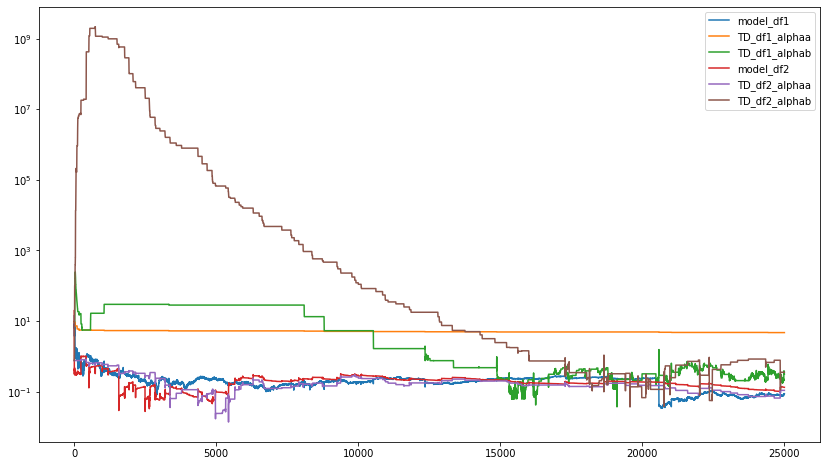

<Figure size 432x288 with 0 Axes>

In [23]:
plt.figure(figsize=(14, 8))


plt.semilogy(df_data['model_df1'], label='model_df1')
plt.semilogy(df_data['TD_df1_alphaa'], label='TD_df1_alphaa')
plt.semilogy(df_data['TD_df1_alphab'], label='TD_df1_alphab')
plt.semilogy(df_data['model_df2'], label='model_df2')
plt.semilogy(df_data['TD_df2_alphaa'], label='TD_df2_alphaa')
plt.semilogy(df_data['TD_df2_alphab'], label='TD_df2_alphab')

plt.legend()
plt.show()
plt.savefig('opg3_4')

